In [2]:
!git clone 'https://github.com/facebookresearch/segment-anything.git'

Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.30 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [3]:
%cd segment-anything

/content/segment-anything


In [4]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [5]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"


from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH = "./sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [6]:
mask_generator = SamAutomaticMaskGenerator(sam)
IMAGE_PATH = "../sample.jpg"

In [14]:
!pip install -q supervision --upgrade supervision

In [34]:
import cv2
import supervision as sv

In [49]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
scale_factor = 1
resized_image = cv2.resize(image_rgb, None, fx=scale_factor, fy=scale_factor)
sam_result = mask_generator.generate(resized_image)

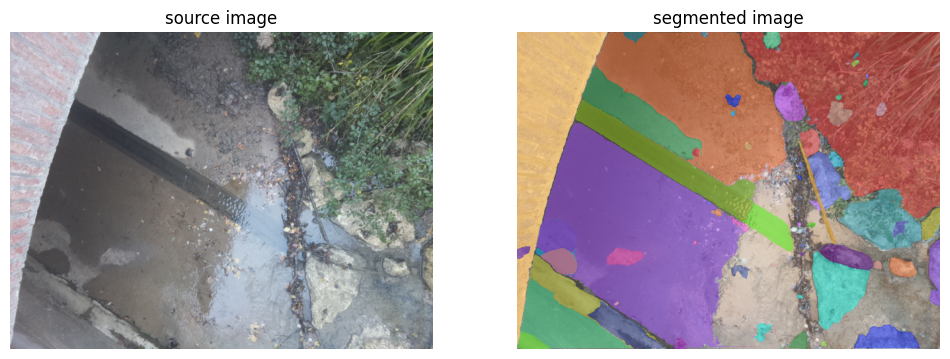

In [50]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=resized_image.copy(), detections=detections)


sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

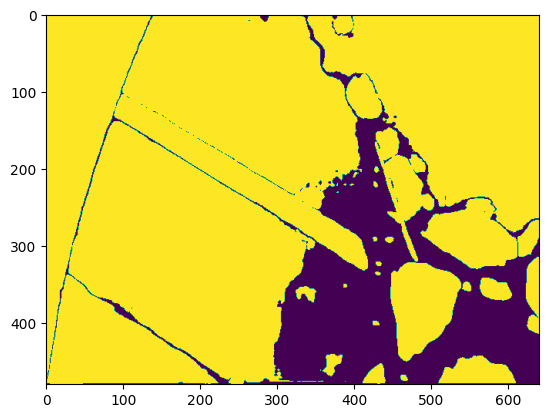

In [51]:
import numpy as np
import matplotlib.pyplot as plt

masks = [o["segmentation"] for o in sam_result]
all_mask = np.zeros(resized_image.shape[:2])
for mask in masks:
  all_mask = np.logical_or(all_mask, mask)
plt.imshow(all_mask.astype(int))

In [ ]:
%cd segment-anything
import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
CHECKPOINT_PATH = "./sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)
import cv2
import supervision as sv

In [90]:
def get_fragments(image_path):
  image_bgr = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  sam_result = mask_generator.generate(image_rgb)
  masks = [o["segmentation"] for o in sam_result]
  all_mask = np.zeros(image_rgb.shape[:2])
  for mask in masks:
    all_mask = np.logical_or(all_mask, mask)
  remaining = np.logical_not(all_mask)
  fragments = [remaining.astype(int)]
  fragments.extend([mask.astype(int) for mask in masks])
  return fragments

In [52]:
import os
from tqdm import tqdm

In [ ]:
!unzip ../water-segmentation-vtx.zip

In [91]:
dir_path = "dataset/trainset/images/"
files = os.listdir(dir_path)
all_fragments = {}

for file in tqdm(files[:20]):
  all_fragments[file] = get_fragments(dir_path + file)

100%|██████████| 20/20 [02:31<00:00,  7.57s/it]


In [97]:
def get_label(frag, file):
  # print(file)
  mask_file = "dataset/trainset/masks/"+file.replace("jpg","png")
  image = cv2.imread(mask_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)//255
  # plt.figure(figsize=(13,5))
  # plt.subplot(1, 3, 1)
  # plt.imshow(image)
  # plt.subplot(1, 3, 2)
  # plt.imshow(frag)
  test = image * frag
  # plt.subplot(1, 3, 3)
  # plt.imshow(test)
  # plt.show()
  return np.sum(test) / np.sum(frag) > .7


file = list(all_fragments.keys())[0]
frag = all_fragments[file][2]
print(get_label(frag, file))

True


In [98]:
training_set = []
for file in all_fragments:
  fragments = all_fragments[file]
  for frag in fragments:
    training_set.append(
        {
            "filename": file,
            "mask": frag.astype(int),
            "size": np.sum(frag.astype(int)),
            "label": get_label(frag, file),
        }
    )